In [5]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import os
from pathlib import Path

In [6]:
scenario = ['PAK', 'RUS', 'HOA', 'URU', 'ALL']

current_dir = Path.cwd()
print(f"Current working directory:", current_dir)

loss_calculation_folder = current_dir / "evaluation"
print("input files at",loss_calculation_folder)

output_dir= loss_calculation_folder / "output"
print("Outout directory for plots at", output_dir) 


scenario = ['PAK', 'RUS', 'HOA', 'URU', 'ALL']


df = {}
for s in scenario:
    filename = loss_calculation_folder / f"{s}-highestLosses.csv"  
    
    if filename.exists():
        try:
            df[s] = pd.read_csv(filename)
            print(f"✓ Loaded: {filename}")
        except Exception as e:
            print(f"× Error loading {filename}: {str(e)}")
    else:
        print(f"! File not found: {filename}")


Current working directory: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project
input files at /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation
Outout directory for plots at /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/output
✓ Loaded: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/PAK-highestLosses.csv
✓ Loaded: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/RUS-highestLosses.csv
✓ Loaded: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/HOA-highestLosses.csv
✓ Loaded: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/URU-highestLosses.csv
✓ Loaded: /Users/valentinbast/uni_codeprojects/compelx_sys_modelling/project/code_project/evaluation/ALL-highestLosses.csv


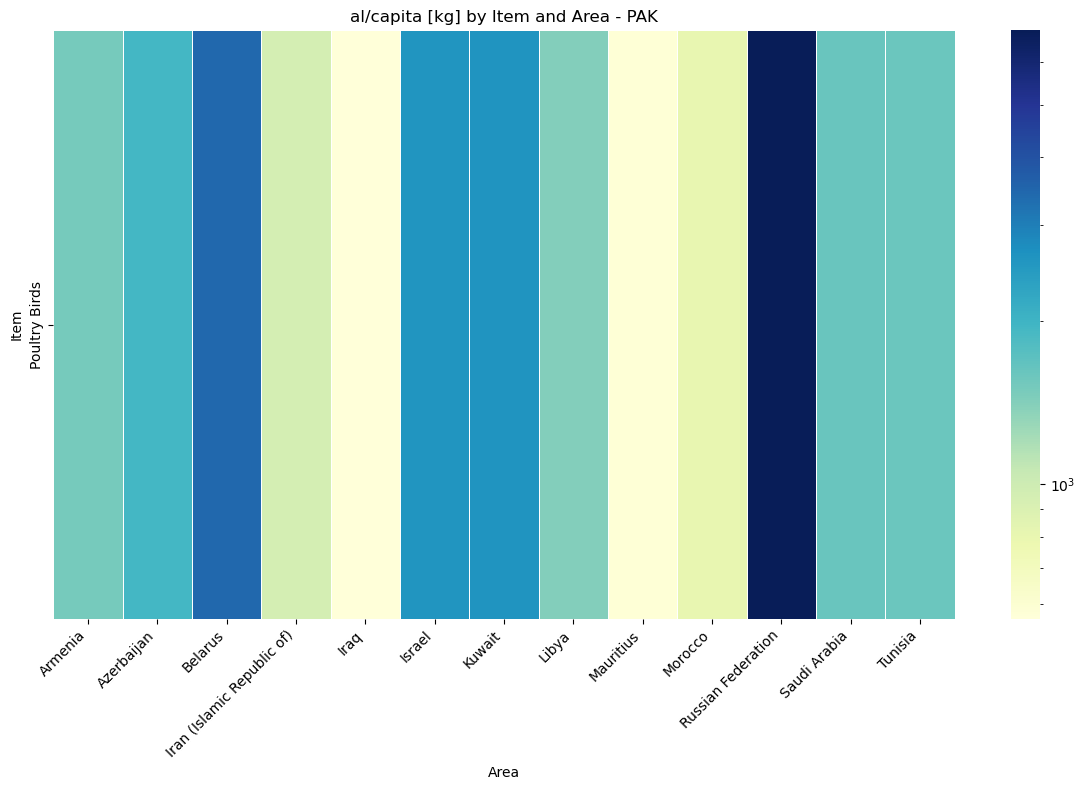

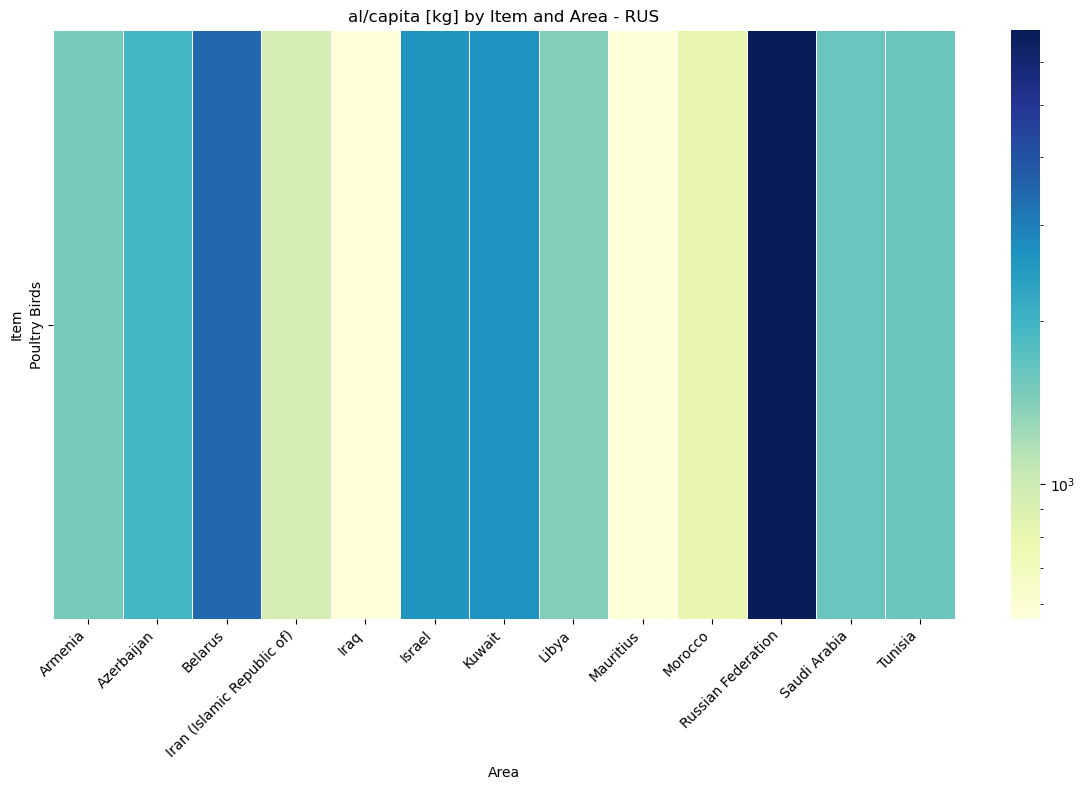

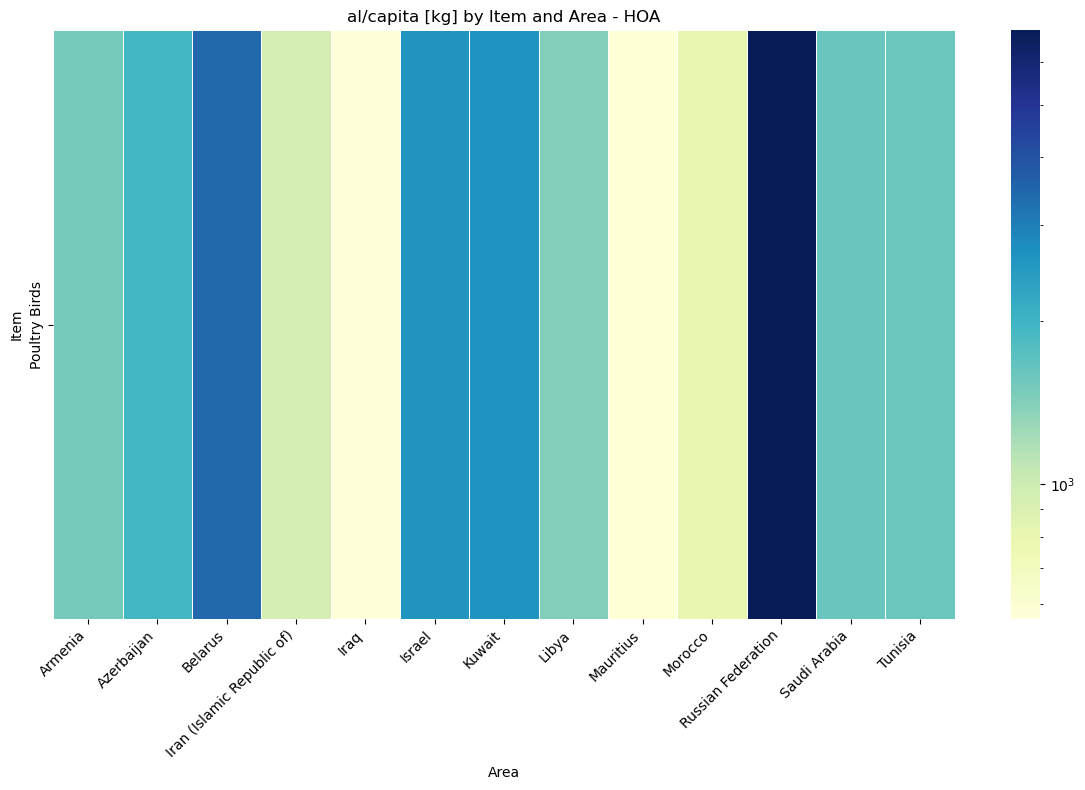

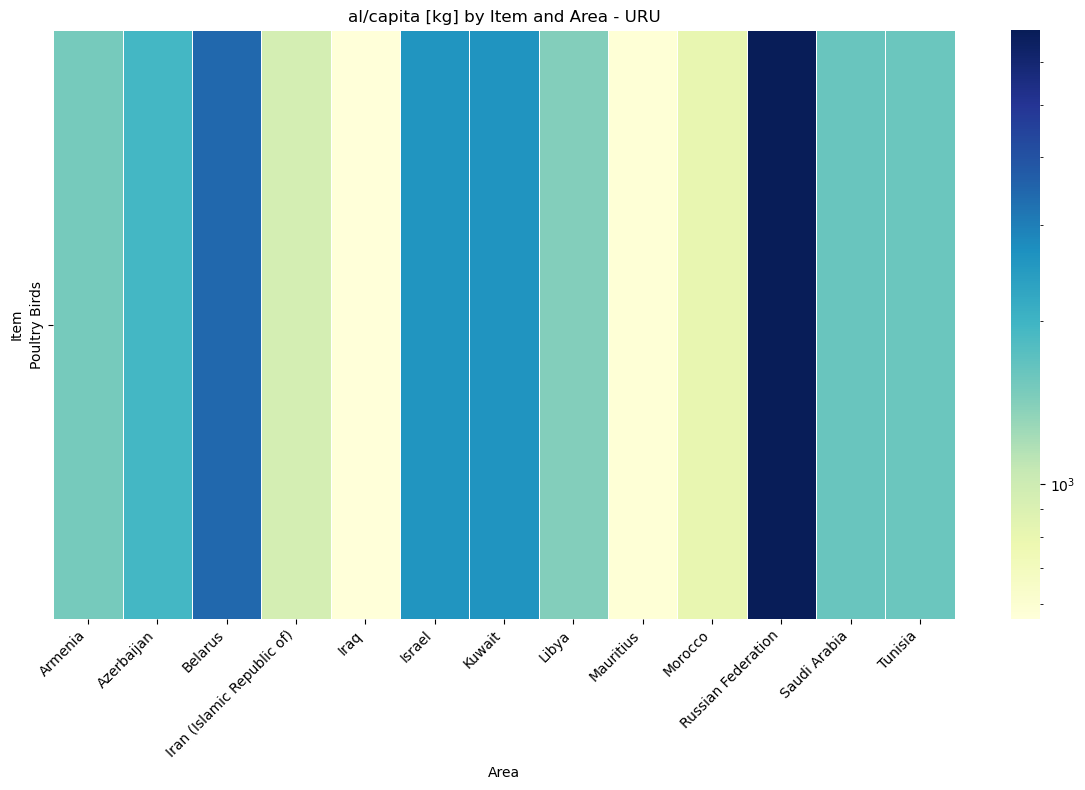

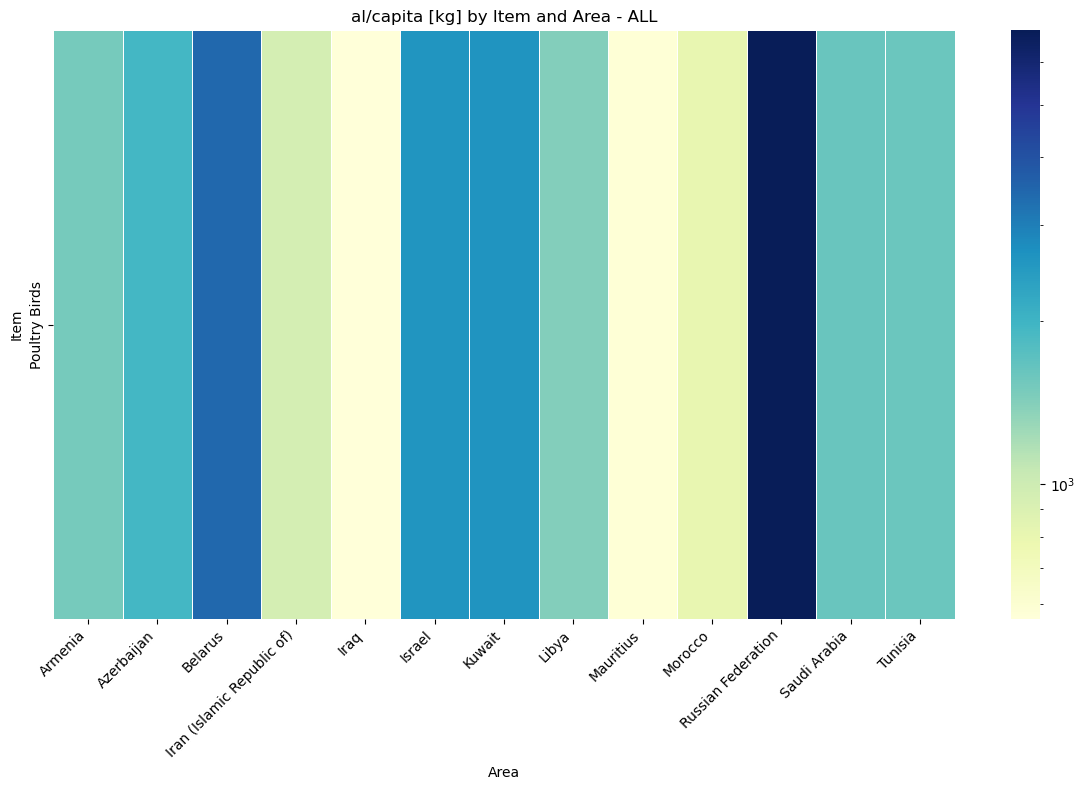

In [8]:
for i in range(len(scenario)):
    # Create pivot table
    pivot_table = df[s].pivot_table(
        index='item',
        columns='area',
        values='al/capita [kg]',
        aggfunc='sum',
        fill_value=0
    )

    # Replace zeros with NaN for log scale compatibility
    masked_data = pivot_table.replace(0, np.nan)

    # Get all positive values (ignoring NaN)
    positive_values = masked_data[masked_data > 0].values.flatten()
    positive_values = positive_values[~np.isnan(positive_values)]

    # Check for valid data
    vmin = positive_values.min() if len(positive_values) > 0 else 1e-6
    vmax = positive_values.max() if len(positive_values) > 0 else 1

    # Define a more varied color palette
    cmap = sns.color_palette("YlGnBu", as_cmap=True)
    cmap.set_bad(color='white')  # for NaN entries

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        masked_data,
        cmap=cmap,
        norm=mcolors.LogNorm(vmin=vmin, vmax=vmax),
        linewidths=0.5
    )
    plot_title = f"al/capita [kg] by Item and Area - {scenario[i]}"
    plt.title(plot_title)
    plt.xlabel("Area")
    plt.ylabel("Item")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Save the plot
    filename = f"al_per_capita_{scenario[i].replace(' ', '_')}.png"
    plt.savefig(os.path.join(output_dir, filename), dpi=300)

    plt.show()

In [9]:
for i in range(len(scenario)):
    data = df[s]
    df_maize = data[data['item'] == 'Rice and products']
    
    maize_losses_by_country = df_maize.groupby('area')['al/capita [kg]'].sum().reset_index()

    # Optional: Clip extreme outliers to enhance readability
    q01 = maize_losses_by_country["al/capita [kg]"].quantile(0.01)
    q99 = maize_losses_by_country["al/capita [kg]"].quantile(0.99)
    maize_losses_by_country["al/capita [kg]"] = maize_losses_by_country["al/capita [kg]"].clip(lower=q01, upper=q99)

    # Get min and max for custom ticks
    min_val = maize_losses_by_country["al/capita [kg]"].min()
    max_val = maize_losses_by_country["al/capita [kg]"].max()

    fig = px.choropleth(
        maize_losses_by_country,
        locations="area",
        locationmode="country names",
        color="al/capita [kg]",
        hover_name="area",
        color_continuous_scale=px.colors.diverging.Spectral[::-1],  # vivid but asymmetric
        title=f"Absolute Losses/c for 'Rice and products' by Country after {scenario[i]}",
        projection="natural earth"
    )

    fig.update_layout(
        coloraxis_colorbar=dict(
            title="kg/capita",
            tickvals=[min_val, 0, max_val],
            ticktext=[f"{min_val:.1f}", "0", f"{max_val:.1f}"],
            len=0.6,
            thickness=15,
        ),
        font=dict(size=14),
        title_x=0.5,
    )

    # Save figure with high resolution
    filename = f"choropleth_maize_losses_{scenario[i].replace(' ', '_')}.png"
    fig.write_image(os.path.join(output_dir, filename), scale=3, width=1200, height=800)

    fig.show()

In [6]:
for i in range(len(scenario)):
    data = df[i]
    df_maize = data[data['item'] == 'Poultry Birds']
    
    maize_losses_by_country = df_maize.groupby('area')['al/capita [kg]'].sum().reset_index()

    # Optional: Clip extreme outliers to enhance readability
    q01 = maize_losses_by_country["al/capita [kg]"].quantile(0.01)
    q99 = maize_losses_by_country["al/capita [kg]"].quantile(0.99)
    maize_losses_by_country["al/capita [kg]"] = maize_losses_by_country["al/capita [kg]"].clip(lower=q01, upper=q99)

    # Get min and max for custom ticks
    min_val = maize_losses_by_country["al/capita [kg]"].min()
    max_val = maize_losses_by_country["al/capita [kg]"].max()

    fig = px.choropleth(
        maize_losses_by_country,
        locations="area",
        locationmode="country names",
        color="al/capita [kg]",
        hover_name="area",
        color_continuous_scale=px.colors.diverging.Spectral[::-1],  # vivid but asymmetric
        title=f"Absolute Losses/c for 'Poultry Birds' by Country after {scenario[i]}",
        projection="natural earth"
    )

    fig.update_layout(
        coloraxis_colorbar=dict(
            title="kg/capita",
            tickvals=[min_val, 0, max_val],
            ticktext=[f"{min_val:.1f}", "0", f"{max_val:.1f}"],
            len=0.6,
            thickness=15,
        ),
        font=dict(size=14),
        title_x=0.5,
    )

    # Save figure with high resolution
    filename = f"choropleth_maize_losses_{scenario[i].replace(' ', '_')}.png"
    fig.write_image(os.path.join(output_dir, filename), scale=3, width=1200, height=800)

    fig.show()

In [7]:
for i in range(len(scenario)):
    data = df[i]
    df_maize = data[data['item'] == 'Maize and products']
    
    maize_losses_by_country = df_maize.groupby('area')['al/capita [kg]'].sum().reset_index()

    # Optional: Clip extreme outliers to enhance readability
    q01 = maize_losses_by_country["al/capita [kg]"].quantile(0.01)
    q99 = maize_losses_by_country["al/capita [kg]"].quantile(0.99)
    maize_losses_by_country["al/capita [kg]"] = maize_losses_by_country["al/capita [kg]"].clip(lower=q01, upper=q99)

    # Get min and max for custom ticks
    min_val = maize_losses_by_country["al/capita [kg]"].min()
    max_val = maize_losses_by_country["al/capita [kg]"].max()

    fig = px.choropleth(
        maize_losses_by_country,
        locations="area",
        locationmode="country names",
        color="al/capita [kg]",
        hover_name="area",
        color_continuous_scale=px.colors.diverging.Spectral[::-1],  # vivid but asymmetric
        title=f"Absolute Losses/c for 'Maize and products' by Country after {scenario[i]}",
        projection="natural earth"
    )

    fig.update_layout(
        coloraxis_colorbar=dict(
            title="kg/capita",
            tickvals=[min_val, 0, max_val],
            ticktext=[f"{min_val:.1f}", "0", f"{max_val:.1f}"],
            len=0.6,
            thickness=15,
        ),
        font=dict(size=14),
        title_x=0.5,
    )

    # Save figure with high resolution
    filename = f"choropleth_maize_losses_{scenario[i].replace(' ', '_')}.png"
    fig.write_image(os.path.join(output_dir, filename), scale=3, width=1200, height=800)

    fig.show()

In [8]:
for i in range(len(scenario)):
    data = df[i]
    df_maize = data[data['item'] == 'Wheat and products']
    
    maize_losses_by_country = df_maize.groupby('area')['al/capita [kg]'].sum().reset_index()

    # Optional: Clip extreme outliers to enhance readability
    q01 = maize_losses_by_country["al/capita [kg]"].quantile(0.01)
    q99 = maize_losses_by_country["al/capita [kg]"].quantile(0.99)
    maize_losses_by_country["al/capita [kg]"] = maize_losses_by_country["al/capita [kg]"].clip(lower=q01, upper=q99)

    # Get min and max for custom ticks
    min_val = maize_losses_by_country["al/capita [kg]"].min()
    max_val = maize_losses_by_country["al/capita [kg]"].max()

    fig = px.choropleth(
        maize_losses_by_country,
        locations="area",
        locationmode="country names",
        color="al/capita [kg]",
        hover_name="area",
        color_continuous_scale=px.colors.diverging.Spectral[::-1],  # vivid but asymmetric
        title=f"Absolute Losses/c for 'Wheat and products' by Country after {scenario[i]}",
        projection="natural earth"
    )

    fig.update_layout(
        coloraxis_colorbar=dict(
            title="kg/capita",
            tickvals=[min_val, 0, max_val],
            ticktext=[f"{min_val:.1f}", "0", f"{max_val:.1f}"],
            len=0.6,
            thickness=15,
        ),
        font=dict(size=14),
        title_x=0.5,
    )

    # Save figure with high resolution
    filename = f"choropleth_maize_losses_{scenario[i].replace(' ', '_')}.png"
    fig.write_image(os.path.join(output_dir, filename), scale=3, width=1200, height=800)

    fig.show()